### 2.5. Problem Statement: Machine Learning 11

In this assignment students have to make ARIMA model over shampoo sales
data and check the MSE between predicted and actual value.
Student can download data in .csv format from the following link:
https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-threeyear-
period#!ds =22r0&display=line

### Loading the Packages

In [158]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
%matplotlib inline


In [13]:
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from statsmodels.graphics.api import qqplot
from pmdarima import auto_arima

In [22]:
def parser(x):
    return datetime.strptime('190'+x, '%YYYY-%mm')

### Reading the DataSet

In [140]:
series = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv")
# setting first name as index column 
series.set_index("Month", inplace = True)  
series.head()

,Sales
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3


In [141]:
series.columns = ['Shampoo Sales']
series.head(1)

,Shampoo Sales
Month,
1-01,266.0


In [85]:
series.reset_index(inplace = True)
series.head(1)

,Month,Shampoo Sales
0,1-01,266.0


### Rolling Mean/ Std.deviation and Sales Plot

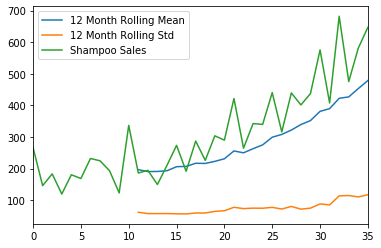

In [86]:
timeseries = series['Shampoo Sales']
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

In [128]:
series.describe()

,Sales
count,36.000000
mean,312.600000
std,148.937164
min,119.300000
25%,192.450000
50%,280.150000
75%,411.100000
max,682.000000


### EDA on Shampoo Sales

In [7]:
series.isna().sum().sum()

0

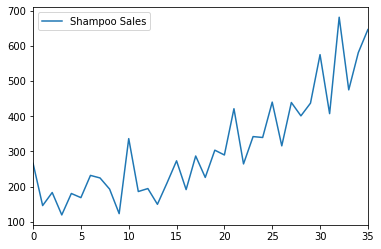

In [50]:
series.plot()
pyplot.show()

### Time Series Decomposition

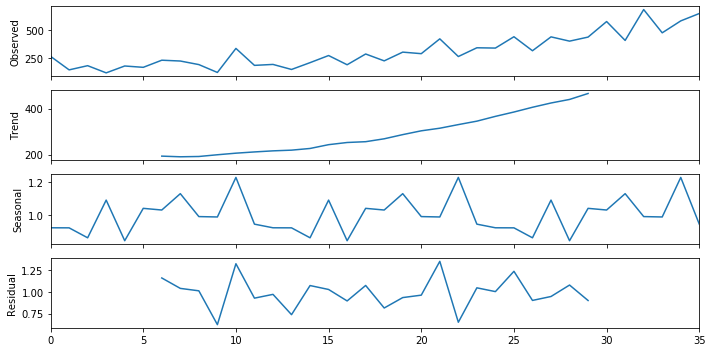

In [51]:
plt.rcParams["figure.figsize"] = [10, 5]
dec=sm.tsa.seasonal_decompose(series[['Shampoo Sales']],freq=12,model='multiplicative')
dec_pt=dec.plot()

### Durbin Watson Test for Serial Correlation 

In [52]:
sm.stats.durbin_watson(series['Shampoo Sales']) #To detect autocorrelation

0.09548538187456361

### Augmented Dickey Fuller Test

In [53]:
from statsmodels.tsa.stattools import adfuller 
adfuller(series['Shampoo Sales'].values)

(3.0601420836411806,
 1.0,
 10,
 25,
 {'1%': -3.7238633119999998, '5%': -2.98648896, '10%': -2.6328004},
 278.9972644263031)

### Adf Function to Check Stationarity

In [56]:
# Store in a function for later 
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

### Finding the Order of Differencing for Shampoo Sales

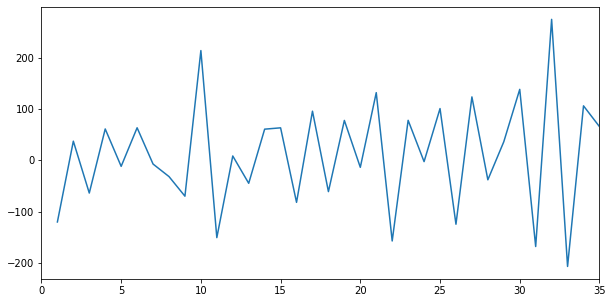

In [54]:
series['Shampoo First Difference'] = series['Shampoo Sales'] - series['Shampoo Sales'].shift(1)
series['Shampoo First Difference'] .plot()

In [57]:
adf_check(series['Shampoo First Difference'] .dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.249074055553854
p-value : 1.7998574141687034e-10
#Lags Used : 1
Number of Observations Used : 33
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


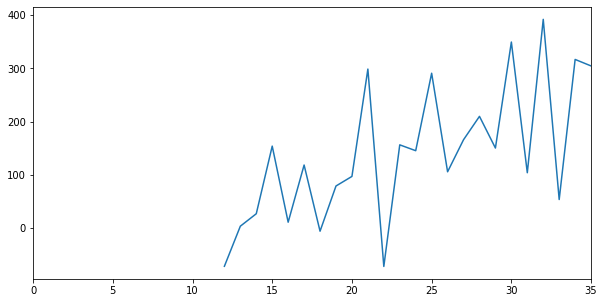

In [58]:
series['Seasonal First Difference'] = series['Shampoo Sales'] - series['Shampoo Sales'].shift(12)
series['Seasonal First Difference'].plot()

In [60]:
adf_check(series['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.04561553414249077
p-value : 0.9545931714075298
#Lags Used : 6
Number of Observations Used : 17
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### Seasonal Differencing and Stationarity Check

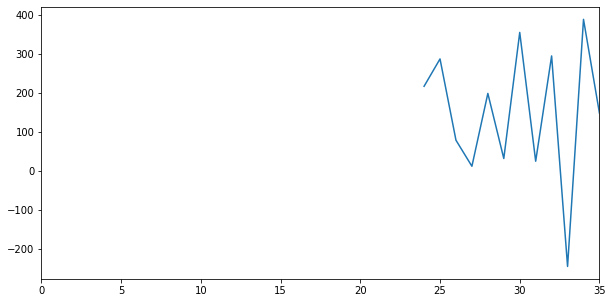

In [62]:
series['Seasonal Second Difference'] = series['Seasonal First Difference'] - series['Seasonal First Difference'].shift(12)
series['Seasonal Second Difference'].plot()

In [63]:
adf_check(series['Seasonal Second Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.6518072821420282
p-value : 0.45609804464525666
#Lags Used : 4
Number of Observations Used : 7
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### ACF & PACF Plots for Seasonal Order Estimation

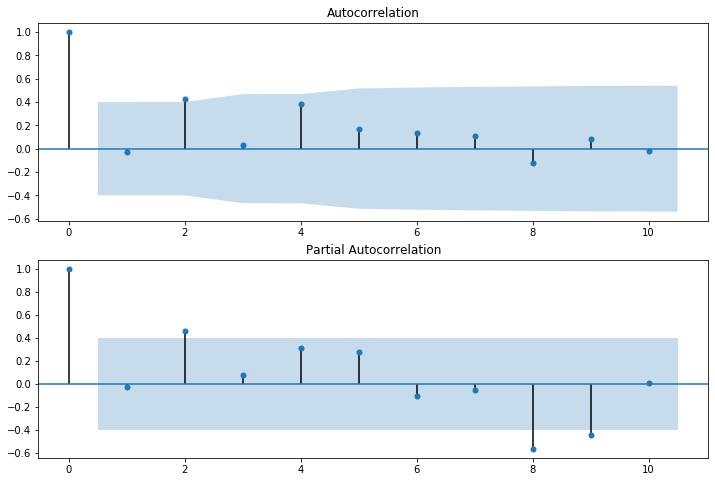

In [66]:
# show plots in the notebook
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series["Seasonal First Difference"].dropna(), lags=10, ax=ax1)  #dta.values.squeeze()
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series["Seasonal First Difference"].dropna(), lags=10, ax=ax2)
#Here ACF - tail off(dying- stationary) & PACF - cut off

### Fitting Model Using Auto Arima 

In [130]:
mymodel = auto_arima(series['Sales'], trace= True, error_action= 'ignore', suppress_warnings = True)
mymodel = mymodel.fit(series['Sales']) 
mymodel.summary()

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=404.571, BIC=413.903, Fit time=0.845 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=430.873, BIC=433.984, Fit time=0.028 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=405.977, BIC=410.643, Fit time=0.202 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=408.967, BIC=413.633, Fit time=0.360 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=429.229, BIC=430.784, Fit time=0.050 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=401.463, BIC=409.240, Fit time=1.336 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=399.527, BIC=405.748, Fit time=0.449 seconds
Near non-invertible roots for order (0, 1, 2)(0, 0, 0, 1); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=402.407, BIC=408.629, Fit time=0.510 seconds
Fi

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -195.763
Date:                Tue, 18 Feb 2020   AIC                            399.527
Time:                        00:41:02   BIC                            405.748
Sample:                             0   HQIC                           401.675
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.4590      7.825      1.209      0.227      -5.877      24.795
ma.L1         -1.3227     40.789     -0.032      0.974     -81.268      78.623
ma.L2          0.9996     61.663      0.016      0.987    -119.858     121.857
sigma2      3526.2644   2.17e+05      0.016      0.987   -4.22e+05    4.29e+05
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.04
Prob(Q):                               nan   Prob(JB):                         0.98
Heteroskedasticity (H):               0.84   Skew:                             0.06
Prob(H) (two-sided):                  0.76   Kurtosis:                         2.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Approach 1 Fitting ARIMA Model

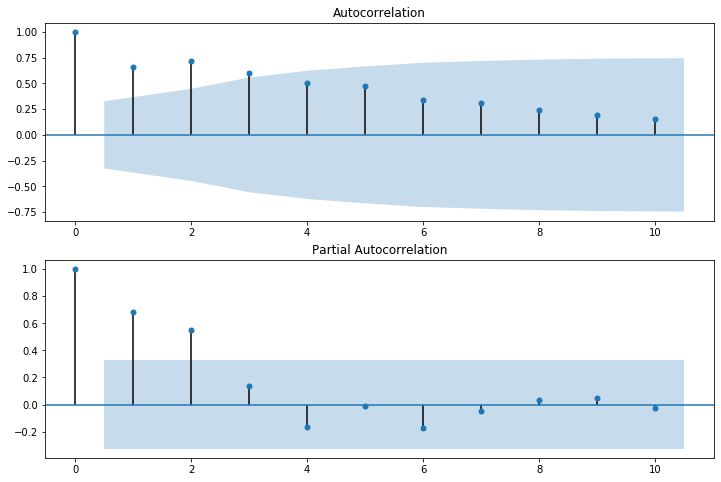

In [163]:
# show plots in the notebook
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series["Shampoo Sales"].dropna(), lags=10, ax=ax1)  #dta.values.squeeze()
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series["Shampoo Sales"].dropna(), lags=10, ax=ax2)
#Here ACF - tail off(dying- stationary) & PACF - cut off

In [112]:

X = series.values
X

array([[266. ],
       [145.9],
       [183.1],
       [119.3],
       [180.3],
       [168.5],
       [231.8],
       [224.5],
       [192.8],
       [122.9],
       [336.5],
       [185.9],
       [194.3],
       [149.5],
       [210.1],
       [273.3],
       [191.4],
       [287. ],
       [226. ],
       [303.6],
       [289.9],
       [421.6],
       [264.5],
       [342.3],
       [339.7],
       [440.4],
       [315.9],
       [439.3],
       [401.3],
       [437.4],
       [575.5],
       [407.6],
       [682. ],
       [475.3],
       [581.3],
       [646.9]])

### Test Train Split 

In [160]:
size = int(len(X) * 0.67)
print(len(X))
print(size)

36
24


In [175]:
train, test = X[0:size], X[size:len(X)]

### Model Fit /Validation and Visualization 

In [172]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

predicted=301.813940, expected=339.700000
predicted=316.960415, expected=440.400000


E:\Anaconda4\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=321.902512, expected=315.900000


E:\Anaconda4\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


predicted=359.566245, expected=439.300000
predicted=371.274859, expected=401.300000
predicted=410.775053, expected=437.400000
predicted=417.838779, expected=575.500000
predicted=441.258070, expected=407.600000
predicted=512.882333, expected=682.000000
predicted=462.954440, expected=475.300000
predicted=617.188465, expected=581.300000
predicted=551.350191, expected=646.900000
Test MSE: 7486.455


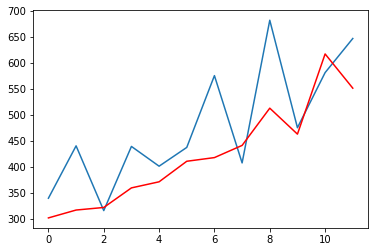

In [173]:
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### Approach 2 : Fitting a SARIMAX Mode Order(1,0,0)

In [146]:

import statsmodels.api as sm
s_arima_model = sm.tsa.statespace.SARIMAX(series['Shampoo Sales'])
s_arima_results = s_arima_model.fit()
print(s_arima_results.summary())

                           Statespace Model Results                           
Dep. Variable:          Shampoo Sales   No. Observations:                   36
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -220.872
Date:                Tue, 18 Feb 2020   AIC                            445.744
Time:                        00:48:58   BIC                            448.911
Sample:                             0   HQIC                           446.849
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9662      0.044     22.071      0.000       0.880       1.052
sigma2      1.159e+04   2908.171      3.984      0.000    5885.111    1.73e+04
Ljung-Box (Q):                         nan   Jarque-

E:\Anaconda4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


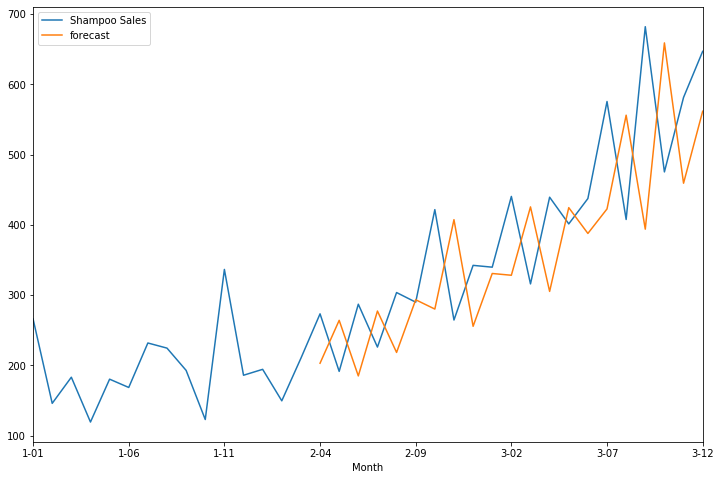

In [150]:
series['forecast'] = s_arima_results.predict(start=15, end=35)
series[['Shampoo Sales','forecast']].plot(figsize=(12,8))

E:\Anaconda4\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


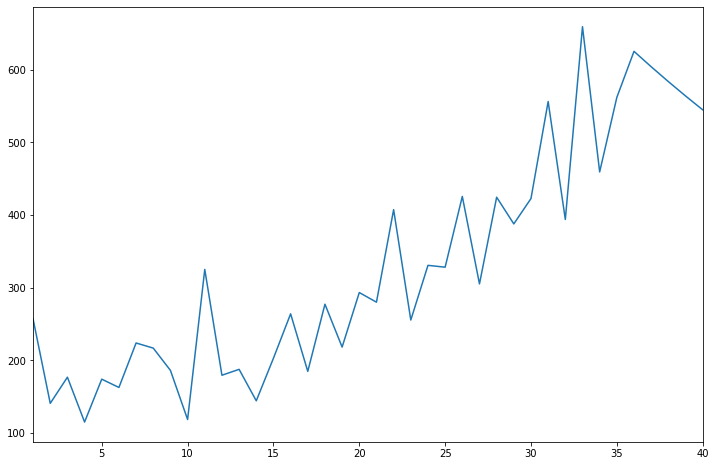

In [155]:
s_arima_results.predict(1,40).plot(figsize=(12,8))

In [ ]:
#--------------------------------------------------------------------#